## Importing Required Libraries

In this section, we import the necessary libraries for data handling, model training, feature selection, and evaluation.

In [35]:
import json
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, Parallel, delayed
from xgboost import XGBClassifier  # XGBoost classifier
from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    accuracy_score
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import seaborn as sns
import warnings  # Import the warnings module
from matplotlib import cm

## Setup and Define Model Parameters

Here we define input parameters such as file paths, hyperparameters, and directories for saving results.

In [36]:
# INPUT DATA
dataset_name = 'SB25r'
reduction_method = '_n0.2_process_filt'
# INPUT PARAMETERS
dataset_fraction = 1
top_N = 25  # You can tune this number to 25, 20, etc.
ffs_features = 25
Early_stopping_threshold = 0.0001 # Early stopping threshold FFS 
# Secondary Parameters
columns_selected = 4
# CPUs
ncpus = max(2, os.cpu_count() // 2)  # Safer for M1 + 8GB RAM
# Hyperparameters for XGBoost
n_estimators = 200
learning_rate = 0.1
max_depth = 6
subsample = 0.8
colsample_bytree = 0.8
r_s = 1

# File Paths
base_path = 'Data_Preparation/InputModel'
model_basepath = 'Models'
model_pic_basepath = 'Models_Pictures'

# Create folders if necessary
for path in [model_basepath]:
    if not os.path.exists(path):
        os.makedirs(path)

## Loading and Preprocessing the Dataset

In this step, we load the dataset, apply basic feature engineering (e.g., calculating cyclical week values and vegetation growth rates), and map numerical crop labels to their respective names.

In [37]:
# Start total timing
total_start_time = time.time()

In [38]:
# Load dataset
output_file = os.path.join(base_path, f'{dataset_name}{reduction_method}.csv')
df = pd.read_csv(output_file)
df = df.sample(frac=dataset_fraction, random_state=1)

In [39]:
# Create interaction features
df["ndvi_soil_moisture"] = df["veg_mean_ndvi"] * df["era5_swi"]
df["precip_temp_ratio"] = df["era5_totprec"] / (df["era5_temp2m"] + 1)

df["ndvi_temp_interaction"] = df["veg_mean_ndvi"] * df["era5_temp2m"]
df["lai_precip_ratio"] = df["veg_mean_lai"] / (df["era5_totprec"] + 1)


In [40]:
# Reorder columns to move 'area_ha' after 'Year'
cols = list(df.columns)
cols.remove('area_ha')
insert_idx = cols.index('Year') + 1
cols.insert(insert_idx, 'area_ha')
df = df[cols]

In [41]:
# print column names
print(df.columns)
print(f"Data shape: {df.shape}")


Index(['FIELDID', 'Crop_type', 'Crop_num', 'Year', 'area_ha', 'week',
       'chirps_mean_prec', 'chirps_sum_prec', 'chirps_max_prec',
       'chirps_min_prec', 'chirps_std_prec', 'chirps_cnt_prec', 'era5_temp2m',
       'era5_temp2mmin', 'era5_temp2max', 'era5_totprec', 'era5_rh',
       'era5_swi', 'era5_evaporation_from_bare_soil_sum', 'veg_mean_evi',
       'veg_mean_lai', 'veg_mean_pvr', 'veg_mean_msi', 'veg_mean_ndvi',
       'veg_median_evi', 'veg_median_lai', 'veg_median_pvr', 'veg_median_msi',
       'veg_median_ndvi', 'veg_max_evi', 'veg_max_lai', 'veg_max_pvr',
       'veg_max_msi', 'veg_max_ndvi', 'veg_min_evi', 'veg_min_lai',
       'veg_min_pvr', 'veg_min_msi', 'veg_min_ndvi', 'veg_std_evi',
       'veg_std_lai', 'veg_std_pvr', 'veg_std_msi', 'veg_std_ndvi', 's1_vh',
       's1_vv', 's1_angle', 's1_sigma_vh_linear', 's1_sigma_vv_linear',
       's1_p_ratio', 's1_rvi', 's1_rcspr', 'Irrigation', 'week_sin',
       'week_cos', 'growth_rate_ndvi', 'growth_rate_evi', 'growth_r

In [42]:
# print unique values in 'Crop_type' and their counts
print(df['Crop_type'].value_counts())
# print the number of unique fields per crop type
print(df.groupby('Crop_type')['FIELDID'].nunique())

Crop_type
Pasture       5555
Maize         5321
Soy           4857
Fallow        2759
Sunflower     1900
Lucern        1608
Tree          1568
Wheat         1188
Groundnuts     321
Sorghum        312
Name: count, dtype: int64
Crop_type
Fallow         97
Groundnuts     11
Lucern         57
Maize         182
Pasture       197
Sorghum        10
Soy           160
Sunflower      70
Tree           40
Wheat          44
Name: FIELDID, dtype: int64


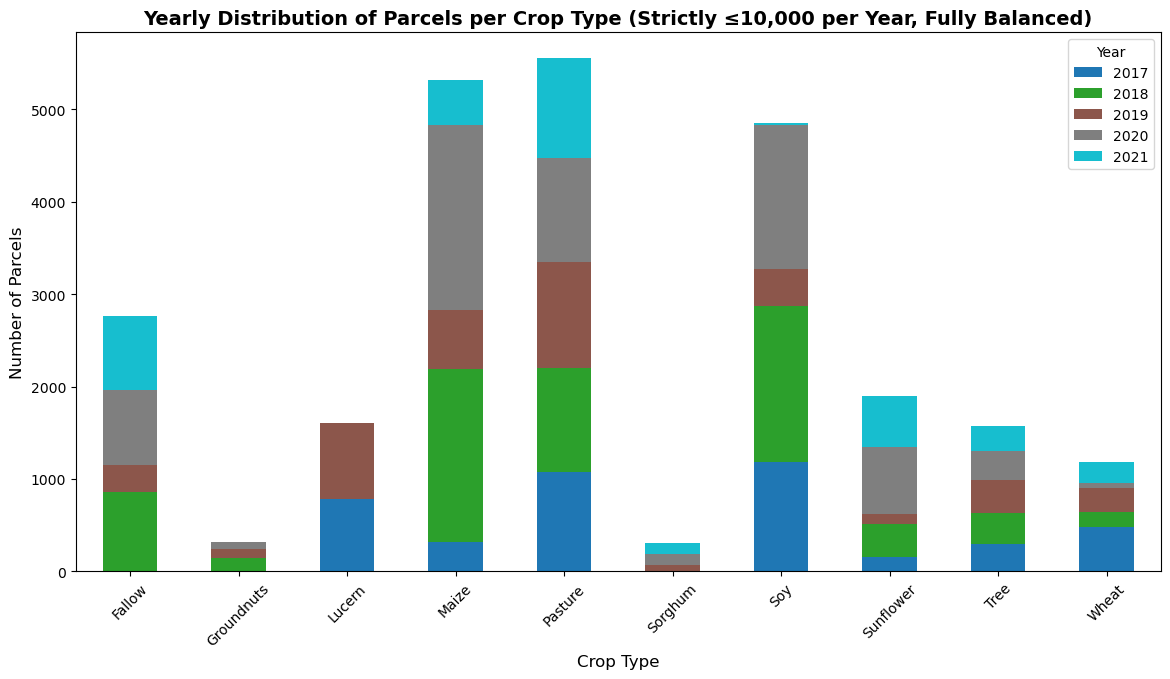

In [43]:
# Verify new unique FIELDID counts per crop and year
crop_year_counts_balanced = df.groupby(["Crop_type", "Year"]).size().unstack()


# Plot the balanced distribution
fig, ax = plt.subplots(figsize=(14, 7))

crop_year_counts_balanced.plot(kind="bar", stacked=True, cmap=cm.get_cmap("tab10"), ax=ax)

ax.set_title("Yearly Distribution of Parcels per Crop Type (Strictly ≤10,000 per Year, Fully Balanced)", fontsize=14, fontweight="bold")
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
# ax.set_ylim(0, 12050)  # ➤ Add y-axis limit here

ax.legend(title="Year")

plt.xticks(rotation=45)
plt.show()


# # # extract only Wheat from df and save as csv file
# df_wheat = df[df['Crop_type'] == 'Wheat']
# output_file = os.path.join(base_path, f'df_Wheat.csv')
# df_wheat.to_csv(output_file, index=False)

In [44]:
# Map numerical labels to crop names
crop_name_mapping = dict(zip(df['Crop_num'].unique(), df['Crop_type'].unique()))

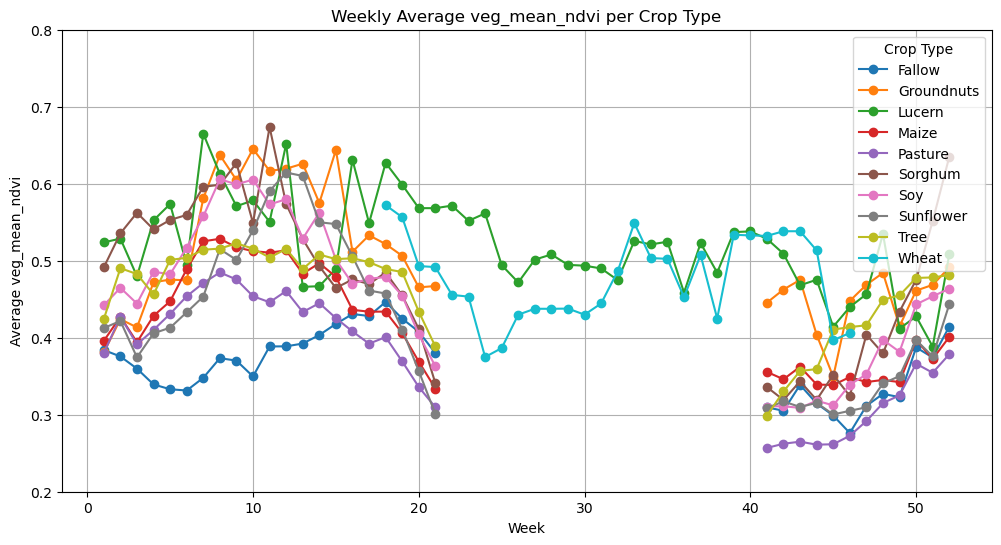

In [45]:
# Ensure 'week' and 'veg_mean_ndvi' are numeric
df.loc[:, "week"] = pd.to_numeric(df["week"], errors="coerce")
df.loc[:, "veg_mean_ndvi"] = pd.to_numeric(df["veg_mean_ndvi"], errors="coerce")


# Compute average veg_mean_ndvi per crop type per week
avg_ndvi_per_crop = df.groupby(["Crop_type", "week"], as_index=False)["veg_mean_ndvi"].mean()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each crop type's average NDVI time series
gap_threshold = 2  # max allowed week gap to keep the line

for crop in avg_ndvi_per_crop["Crop_type"].unique():
    subset = avg_ndvi_per_crop[avg_ndvi_per_crop["Crop_type"] == crop].sort_values("week")
    weeks = subset["week"].values
    ndvi_values = subset["veg_mean_ndvi"].values

    # Insert NaN where the gap is larger than threshold
    new_weeks = []
    new_ndvi = []
    for i in range(len(weeks)):
        new_weeks.append(weeks[i])
        new_ndvi.append(ndvi_values[i])
        if i < len(weeks) - 1 and (weeks[i+1] - weeks[i]) > gap_threshold:
            new_weeks.append(np.nan)
            new_ndvi.append(np.nan)

    plt.plot(new_weeks, new_ndvi, marker="o", linestyle="-", label=crop)

# Customize the plot
plt.xlabel("Week")
plt.ylabel("Average veg_mean_ndvi")
plt.title("Weekly Average veg_mean_ndvi per Crop Type")
plt.legend(title="Crop Type")
plt.grid(True)
plt.ylim(0.2, 0.8)

# Show the plot
plt.show()

In [46]:
# Define predictors and labels
predictors = df.columns[columns_selected:]
# print the predictors
print(f"Predictors: {predictors}")
label_col = 'Crop_num'

Predictors: Index(['area_ha', 'week', 'chirps_mean_prec', 'chirps_sum_prec',
       'chirps_max_prec', 'chirps_min_prec', 'chirps_std_prec',
       'chirps_cnt_prec', 'era5_temp2m', 'era5_temp2mmin', 'era5_temp2max',
       'era5_totprec', 'era5_rh', 'era5_swi',
       'era5_evaporation_from_bare_soil_sum', 'veg_mean_evi', 'veg_mean_lai',
       'veg_mean_pvr', 'veg_mean_msi', 'veg_mean_ndvi', 'veg_median_evi',
       'veg_median_lai', 'veg_median_pvr', 'veg_median_msi', 'veg_median_ndvi',
       'veg_max_evi', 'veg_max_lai', 'veg_max_pvr', 'veg_max_msi',
       'veg_max_ndvi', 'veg_min_evi', 'veg_min_lai', 'veg_min_pvr',
       'veg_min_msi', 'veg_min_ndvi', 'veg_std_evi', 'veg_std_lai',
       'veg_std_pvr', 'veg_std_msi', 'veg_std_ndvi', 's1_vh', 's1_vv',
       's1_angle', 's1_sigma_vh_linear', 's1_sigma_vv_linear', 's1_p_ratio',
       's1_rvi', 's1_rcspr', 'Irrigation', 'week_sin', 'week_cos',
       'growth_rate_ndvi', 'growth_rate_evi', 'growth_rate_lai',
       'mean_combined_

In [47]:
# Drop rows with NaNs or infinite values in selected predictors or label
df_clean = df[[label_col] + list(predictors)].replace([np.inf, -np.inf], np.nan).dropna()

# Reassign cleaned data
X = df_clean[predictors].values
y = df_clean[label_col].values.ravel()


## Train the Initial XGBoost Model

We train the first XGBoost model on the dataset using the defined parameters.

In [48]:
from sklearn.utils.class_weight import compute_sample_weight

# 🔹 Compute Sample Weights (Higher for Wheat)
sample_weights = compute_sample_weight(class_weight="balanced", y=y)

# 🔹 Define XGBoost Model with the same parameters
xgb = XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    random_state=r_s,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    n_jobs=ncpus
)

# 🔹 Train the Model Using Sample Weights
xgb.fit(X, y, sample_weight=sample_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=4,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Feature Importance and Selection

We display feature importance, select the top N features, and retrain the XGBoost model with the selected features.

In [49]:
# Display feature importance
feature_importances = pd.DataFrame(xgb.feature_importances_, index=predictors, columns=['importance']).sort_values('importance', ascending=False)

In [50]:
# Select top N most important features before FFS (e.g., top 30)
feature_importances = pd.DataFrame(xgb.feature_importances_, index=predictors, columns=['importance'])
top_features = feature_importances.sort_values('importance', ascending=False).index[:top_N].tolist()

# Subset the data for FFS
df1 = df[[label_col] + top_features]
X1 = df1[top_features].values
y = df1[label_col].values.ravel()
predictors1 = df1.columns[1:]


In [51]:
# print the columns selected
print(df1.columns)
print(df1.shape)

Index(['Crop_num', 'Irrigation', 'veg_std_ndvi', 'week', 'area_ha', 'week_cos',
       'chirps_cnt_prec', 'week_sin', 'veg_median_pvr',
       'ndvi_temp_interaction', 'era5_evaporation_from_bare_soil_sum',
       'era5_temp2mmin', 's1_vv', 'era5_swi', 'ndvi_soil_moisture',
       'veg_std_lai', 's1_vh', 'growth_rate_lai', 'veg_mean_ndvi',
       'veg_median_msi', 'veg_std_msi', 'lai_precip_ratio', 'era5_temp2max',
       's1_sigma_vv_linear', 's1_sigma_vh_linear', 'veg_median_ndvi'],
      dtype='object')
(25389, 26)


In [52]:
# 🔹 Compute Sample Weights for Retraining
sample_weights1 = compute_sample_weight(class_weight="balanced", y=y)

# 🔹 Retrain XGBoost model with selected features
xgb1 = XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    random_state=r_s,
    n_jobs=ncpus
)

# 🔹 Train the Model Using Sample Weights
xgb1.fit(X1, y, sample_weight=sample_weights1)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=4,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Forward Feature Selection (FFS)

We perform Forward Feature Selection (FFS) using Stratified K-Folds cross-validation to identify the best feature subset.

In [53]:
from sklearn.model_selection import GroupKFold, StratifiedShuffleSplit
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np

# ➤ Add GroupID to df1 (top-N feature dataset)
df1 = df1.copy()
df1["GroupID"] = df.loc[df1.index, "FIELDID"].astype(str) + "_" + df.loc[df1.index, "Year"].astype(str)

# ➤ Collapse to one row per group for stratified sampling
group_df = df1.groupby("GroupID").first().reset_index()  # Includes Crop_num

# ➤ UPDATED: Use 2019 as test year to include all crop types
train_years = [2016, 2017, 2018, 2020, 2021]
test_years = [2019]

# Extract year from GroupID
group_df["Year"] = group_df["GroupID"].str.split("_").str[1].astype(int)

# Assign group IDs
sampled_groups = group_df[group_df["Year"].isin(train_years)]["GroupID"].values
test_groups = group_df[group_df["Year"].isin(test_years)]["GroupID"].values

# ➤ Verifications
print(f"📅 Train years: {train_years} — Test year: {test_years}")
print(f"🔢 Train groups: {len(sampled_groups)} — Test groups: {len(test_groups)}")

# Check for overlap (should be zero)
overlap = set(sampled_groups).intersection(set(test_groups))
print(f"🔍 Overlap between training and test groups: {len(overlap)}")
assert len(test_groups) > 0, "⚠️ No test groups found for the given test_years."

# ✅ Check all crop classes are present in test set
test_labels_present = np.unique(df1.loc[df1["GroupID"].isin(test_groups), label_col])
all_labels = np.unique(df1[label_col])
missing_classes = set(all_labels) - set(test_labels_present)
assert not missing_classes, f"⚠️ Missing classes in test set: {missing_classes}"

# ➤ Class distribution in FFS sample
sampled_labels = df1.loc[df1["GroupID"].isin(sampled_groups), label_col]
print("✔️ Class distribution in FFS sample:")
print(sampled_labels.value_counts().sort_index())

# ➤ Subsample for FFS
sample_mask = df1["GroupID"].isin(sampled_groups)
X_small = df1.loc[sample_mask, predictors1].values
y_small = df1.loc[sample_mask, label_col].values.ravel()
groups_small = df1.loc[sample_mask, "GroupID"].values

# ➤ Use GroupKFold for cross-validation
cv = GroupKFold(n_splits=2)

# ➤ FFS Estimator: lightweight XGBoost
ffs_estimator = XGBClassifier(
    n_estimators=50,              # Faster FFS
    learning_rate=0.2,            # Speed up convergence
    max_depth=4,                  # Shallower trees
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=r_s,
    n_jobs=ncpus
)

# ➤ Forward Feature Selection (with floating=True for backward steps)
sfs = SFS(
    estimator=ffs_estimator,
    k_features=ffs_features,      # Your desired number of features
    forward=True,
    floating=True,                # ✅ Enables backward feature removal
    scoring='accuracy',
    cv=list(cv.split(X_small, y_small, groups_small)),
    n_jobs=ncpus,
    clone_estimator=False
)

# ⏱️ Run FFS
start_time = time.time()
sfs = sfs.fit(X_small, y_small)
end_time = time.time()
elapsed = end_time - start_time
print(f"✔️ FFS (with floating) completed in {elapsed / 60:.2f} minutes")


📅 Train years: [2016, 2017, 2018, 2020, 2021] — Test year: [2019]
🔢 Train groups: 774 — Test groups: 144
🔍 Overlap between training and test groups: 0
✔️ Class distribution in FFS sample:
Crop_num
0    4680
1    4466
2    1790
3     925
4     779
5    4410
6    1211
7    2470
8     226
9     238
Name: count, dtype: int64
✔️ FFS (with floating) completed in 17.51 minutes


In [54]:
# Optional: Save FFS progress (converted for JSON compatibility)
import numpy as np

def convert_ndarrays(obj):
    if isinstance(obj, dict):
        return {k: convert_ndarrays(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_ndarrays(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

metric_dict_clean = convert_ndarrays(sfs.get_metric_dict())


In [55]:
# ➤ Log selected features and their CV scores
print("\n📊 Selected Features and Cross-Val Accuracy Scores:")
metric_dict = sfs.get_metric_dict()

# Build a ranked list
selected_features = []
for k in sorted(metric_dict.keys()):
    feat_idx = metric_dict[k]['feature_idx']
    feat_names = [predictors1[i] for i in feat_idx]
    acc = metric_dict[k]['avg_score']
    print(f"{k:2d} features | Accuracy: {acc:.4f} | Features: {feat_names}")
    selected_features.append((k, acc, feat_names))

# ➤ Save to CSV (optional)
import pandas as pd
ffs_summary = pd.DataFrame([
    {"Num_Features": k, "Accuracy": acc, "Features": ", ".join(flist)}
    for k, acc, flist in selected_features
])
# ffs_summary.to_csv("ffs_feature_scores.csv", index=False)



📊 Selected Features and Cross-Val Accuracy Scores:
 1 features | Accuracy: 0.3023 | Features: ['veg_std_lai']
 2 features | Accuracy: 0.3415 | Features: ['week', 'veg_std_lai']
 3 features | Accuracy: 0.3964 | Features: ['week', 'era5_temp2mmin', 'veg_std_lai']
 4 features | Accuracy: 0.4288 | Features: ['week', 'veg_median_pvr', 'era5_temp2mmin', 'veg_std_lai']
 5 features | Accuracy: 0.4578 | Features: ['week', 'veg_median_pvr', 'era5_temp2mmin', 'veg_std_lai', 'veg_mean_ndvi']
 6 features | Accuracy: 0.4806 | Features: ['week', 'veg_median_pvr', 'era5_temp2mmin', 'veg_std_lai', 'veg_mean_ndvi', 's1_sigma_vv_linear']
 7 features | Accuracy: 0.4951 | Features: ['week', 'veg_median_pvr', 'era5_temp2mmin', 'era5_swi', 'veg_std_lai', 'veg_mean_ndvi', 's1_sigma_vv_linear']
 8 features | Accuracy: 0.5145 | Features: ['Irrigation', 'week', 'veg_median_pvr', 'era5_temp2mmin', 'era5_swi', 'veg_std_lai', 'veg_mean_ndvi', 's1_sigma_vv_linear']
 9 features | Accuracy: 0.5216 | Features: ['Irrig

## Plotting Cumulative Accuracy Improvement

We plot the cumulative accuracy improvement from the Forward Feature Selection.

In [56]:
selected_columns = df1.drop(label_col, axis=1).columns[list(sfs.k_feature_idx_)]

# Cumulative plot of FFS accuracy improvement
metric_dict = sfs.get_metric_dict()

# Extract the accuracy scores and the newly added feature at each step
new_features = []
accuracies = []

# Get the list of feature names excluding the label column
feature_names = df1.drop('Crop_num', axis=1).columns

for i, key in enumerate(metric_dict.keys()):
    accuracies.append(metric_dict[key]['avg_score'])
    if i == 0:
        new_features.append(feature_names[list(metric_dict[key]['feature_idx'])][0])  # First feature added
    else:
        # Find the newly added feature by comparing the feature sets
        previous_set = set(metric_dict[key - 1]['feature_idx'])
        current_set = set(metric_dict[key]['feature_idx'])
        new_feature = current_set - previous_set
        new_features.append(feature_names[list(new_feature)][0])

In [57]:
# Cumulative plot of FFS accuracy improvement with early stopping
metric_dict = sfs.get_metric_dict()
feature_names = df1.drop(label_col, axis=1).columns

# Sort keys to ensure ordered access
keys = sorted(metric_dict)

# ✅ Improved early stopping: pick point before accuracy gain drops consistently
threshold = Early_stopping_threshold
best_index = len(accuracies) - 1  # fallback to last if no drop found

for i in range(1, len(accuracies)):
    improvement = accuracies[i] - accuracies[i - 1]
    if improvement < threshold:
        # check if the gain has plateaued
        if i + 1 < len(accuracies):
            if (accuracies[i + 1] - accuracies[i]) < threshold:
                best_index = i
                break


# Get selected feature indices at best_index
# Select feature set with highest accuracy
best_key = max(metric_dict.items(), key=lambda x: x[1]['avg_score'])[0]
final_idx = list(metric_dict[best_key]['feature_idx'])
selected_columns = feature_names[final_idx]

print(f"✔️ Best-scoring feature set has {len(selected_columns)} features, accuracy = {metric_dict[best_key]['avg_score']:.4f}")


# Get list of newly added features for plotting
new_features = []
for i, k in enumerate(keys[:best_index + 1]):
    if i == 0:
        new_features.append(feature_names[list(metric_dict[k]['feature_idx'])[0]])
    else:
        prev = set(metric_dict[keys[i - 1]]['feature_idx'])
        curr = set(metric_dict[k]['feature_idx'])
        new_feat = curr - prev
        if new_feat:
            new_features.append(feature_names[list(new_feat)[0]])
        else:
            new_features.append("")

# Trim accuracies and new_features to best_index
accuracies = accuracies[:best_index + 1]



✔️ Best-scoring feature set has 17 features, accuracy = 0.5378


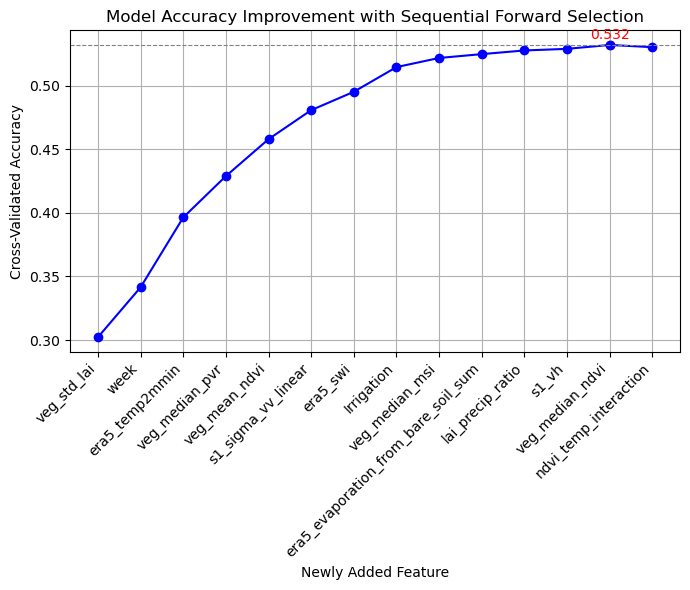

✔️ Feature importance plot saved to: Models_Pictures/SB25r_n0.2_process_filt_ffs_accuracy_improvement.png


In [58]:
plt.figure(figsize=(7, 6))
plt.plot(new_features, accuracies, marker='o', linestyle='-', color='b')

# Highlight max accuracy
max_acc = max(accuracies)
plt.axhline(y=max_acc, color='gray', linestyle='--', linewidth=0.8)

# Mark the elbow point
best_idx = np.argmax(accuracies)
plt.scatter(best_idx, accuracies[best_idx], color='red')
plt.text(best_idx, accuracies[best_idx] + 0.005, f'{accuracies[best_idx]:.3f}', ha='center', color='red')

# Rotate labels
plt.xticks(rotation=45, ha='right')

plt.title('Model Accuracy Improvement with Sequential Forward Selection')
plt.xlabel('Newly Added Feature')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.tight_layout()

# Save plot
fig_path = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_ffs_accuracy_improvement.png")
plt.savefig(fig_path)
plt.show()

print(f"✔️ Feature importance plot saved to: {fig_path}")


## Train the Final XGBoost Model

We train the final XGBoost model using the features selected by FFS.

In [59]:
df2 = df1[[label_col] + list(selected_columns)].copy()  # 🔸 Add .copy() here
df2.loc[:, "Year"] = df.loc[df2.index, "Year"].values

X2 = df2[selected_columns].values
y = df2[label_col].values.ravel()
predictors2 = df2.columns[1:]


In [60]:
# 🔹 Define Final Model
xgb2 = XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    random_state=r_s,
    n_jobs=ncpus,
    eval_metric="mlogloss",             # ✅ now correctly placed
    early_stopping_rounds=20            # ✅ now correctly placed
)

# 🔹 Compute Sample Weights for Final Model
sample_weights2 = compute_sample_weight(class_weight="balanced", y=y)

# 🔹 Split into training and validation sets (stratified by class)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val, sw_train, sw_val = train_test_split(
    X2, y, sample_weights2, test_size=0.2, random_state=1, stratify=y
)

# 🔹 Train the Final Model with Early Stopping
xgb2.fit(
    X_train, y_train,
    sample_weight=sw_train,
    eval_set=[(X_val, y_val)],
    sample_weight_eval_set=[sw_val],
    verbose=True
)

# ✅🧪 Evaluate on True Test Set
test_mask = df1["GroupID"].isin(test_groups)
X_test = df1.loc[test_mask, selected_columns].values
y_test = df1.loc[test_mask, label_col].values.ravel()

from sklearn.metrics import classification_report
y_test_pred = xgb2.predict(X_test)
print("🧪 Evaluation on True Test Set:")
print(classification_report(y_test, y_test_pred, digits=3))


# 🔹 Save classification report to JSON
report = classification_report(y_test, y_test_pred, digits=3, output_dict=True)

report_path = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_true_test_report.json")
with open(report_path, "w") as f:
    json.dump(report, f, indent=2)

print(f"📝 True test report saved to: {report_path}")



[0]	validation_0-mlogloss:2.19675
[1]	validation_0-mlogloss:2.10718
[2]	validation_0-mlogloss:2.03162
[3]	validation_0-mlogloss:1.96923
[4]	validation_0-mlogloss:1.91558
[5]	validation_0-mlogloss:1.86331
[6]	validation_0-mlogloss:1.81755
[7]	validation_0-mlogloss:1.77756
[8]	validation_0-mlogloss:1.74153
[9]	validation_0-mlogloss:1.70894
[10]	validation_0-mlogloss:1.67609
[11]	validation_0-mlogloss:1.64689
[12]	validation_0-mlogloss:1.62035
[13]	validation_0-mlogloss:1.59641
[14]	validation_0-mlogloss:1.57336
[15]	validation_0-mlogloss:1.55151
[16]	validation_0-mlogloss:1.52993
[17]	validation_0-mlogloss:1.51108
[18]	validation_0-mlogloss:1.49101
[19]	validation_0-mlogloss:1.47419
[20]	validation_0-mlogloss:1.45971
[21]	validation_0-mlogloss:1.44281
[22]	validation_0-mlogloss:1.42754
[23]	validation_0-mlogloss:1.41414
[24]	validation_0-mlogloss:1.40110
[25]	validation_0-mlogloss:1.38917
[26]	validation_0-mlogloss:1.37831
[27]	validation_0-mlogloss:1.36782
[28]	validation_0-mlogloss:1.3

In [61]:
# ✅🧪 Evaluate on True Test Set
test_mask = df1["GroupID"].isin(test_groups)
X_test = df1.loc[test_mask, selected_columns].values
y_test = df1.loc[test_mask, label_col].values.ravel()

from sklearn.metrics import classification_report
y_test_pred = xgb2.predict(X_test)
print("🧪 Evaluation on True Test Set:")
print(classification_report(y_test, y_test_pred, digits=3))

# 🔹 Generate confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
labels = sorted(np.unique(y_test))  # or use your class labels directly

# 🔹 Plot and save confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - True Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

cm_image_path = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_confusion_matrix.png")
plt.tight_layout()
plt.savefig(cm_image_path)
plt.close()

print(f"📊 Confusion matrix image saved to: {cm_image_path}")

# 🔹 Optionally save the raw values as CSV
cm_csv_path = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_confusion_matrix.csv")
pd.DataFrame(cm, index=labels, columns=labels).to_csv(cm_csv_path)
print(f"📊 Confusion matrix CSV saved to: {cm_csv_path}")


🧪 Evaluation on True Test Set:
              precision    recall  f1-score   support

           0      0.763     0.649     0.702       641
           1      0.820     0.711     0.762       391
           2      0.763     0.818     0.789       110
           3      0.935     0.924     0.929       263
           4      0.919     0.963     0.940       829
           5      0.861     0.819     0.839      1145
           6      0.763     0.958     0.850       357
           7      0.738     0.848     0.789       289
           8      0.718     0.937     0.813        95
           9      0.971     0.919     0.944        74

    accuracy                          0.836      4194
   macro avg      0.825     0.855     0.836      4194
weighted avg      0.838     0.836     0.834      4194

📊 Confusion matrix image saved to: Models_Pictures/SB25r_n0.2_process_filt_confusion_matrix.png
📊 Confusion matrix CSV saved to: Models_Pictures/SB25r_n0.2_process_filt_confusion_matrix.csv


## Feature Importance of Final Model

We display and save the feature importance for the final model.

In [62]:
feature_importances_final = pd.DataFrame(
    xgb2.feature_importances_, 
    index=selected_columns, 
    columns=['importance']
).sort_values('importance', ascending=False)

Text(0, 0.5, 'Features')

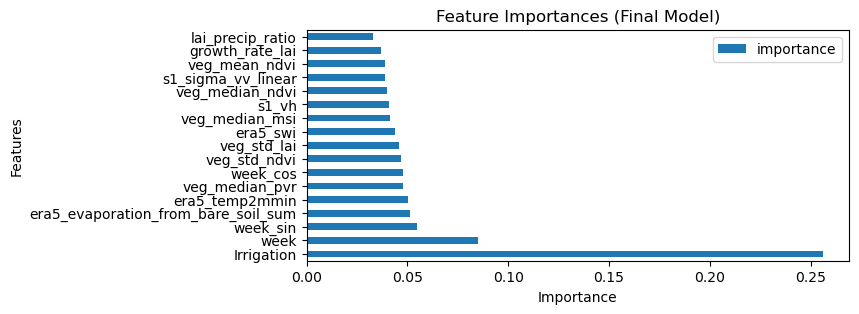

In [63]:
# Plot and save feature importance
fig, ax = plt.subplots(figsize=(7, 3))
feature_importances_final.plot(kind='barh', ax=ax)
ax.set_title('Feature Importances (Final Model)')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')

## Model Evaluation and Confusion Matrix

We assess the model’s performance using cross-validation and display a confusion matrix.

In [64]:
# Combine FIELDID and Year to create a unique group identifier
df2 = df2.copy()
df2["GroupID"] = df.loc[df2.index, "FIELDID"].astype(str) + "_" + df.loc[df2.index, "Year"].astype(str)
groups = df2["GroupID"].values

In [65]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict

# 🔹 Redefine a new model for cross-validation (no early stopping)
xgb_cv = XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    random_state=r_s,
    n_jobs=ncpus,
    eval_metric="mlogloss"  # optional: keeps evaluation consistent
)

# 🔹 5-fold Stratified CV
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)

overall_acc = cross_val_score(xgb_cv, X2, y, cv=gkf, groups=groups, scoring='accuracy', n_jobs=ncpus)
f1_macro = cross_val_score(xgb_cv, X2, y, cv=gkf, groups=groups, scoring='f1_macro', n_jobs=ncpus)
predictions = cross_val_predict(xgb_cv, X2, y, cv=gkf, groups=groups, n_jobs=ncpus)



In [66]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# 🔹 Explicit Crop_num order and names
class_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
crop_name_mapping = {
    0: 'Maize',
    1: 'Soy',
    2: 'Sunflower',
    3: 'Wheat',
    4: 'Lucern',
    5: 'Pasture',
    6: 'Tree',
    7: 'Fallow',
    8: 'Groundnuts',
    9: 'Sorghum'
}
class_names_ordered = [crop_name_mapping[i] for i in class_order]


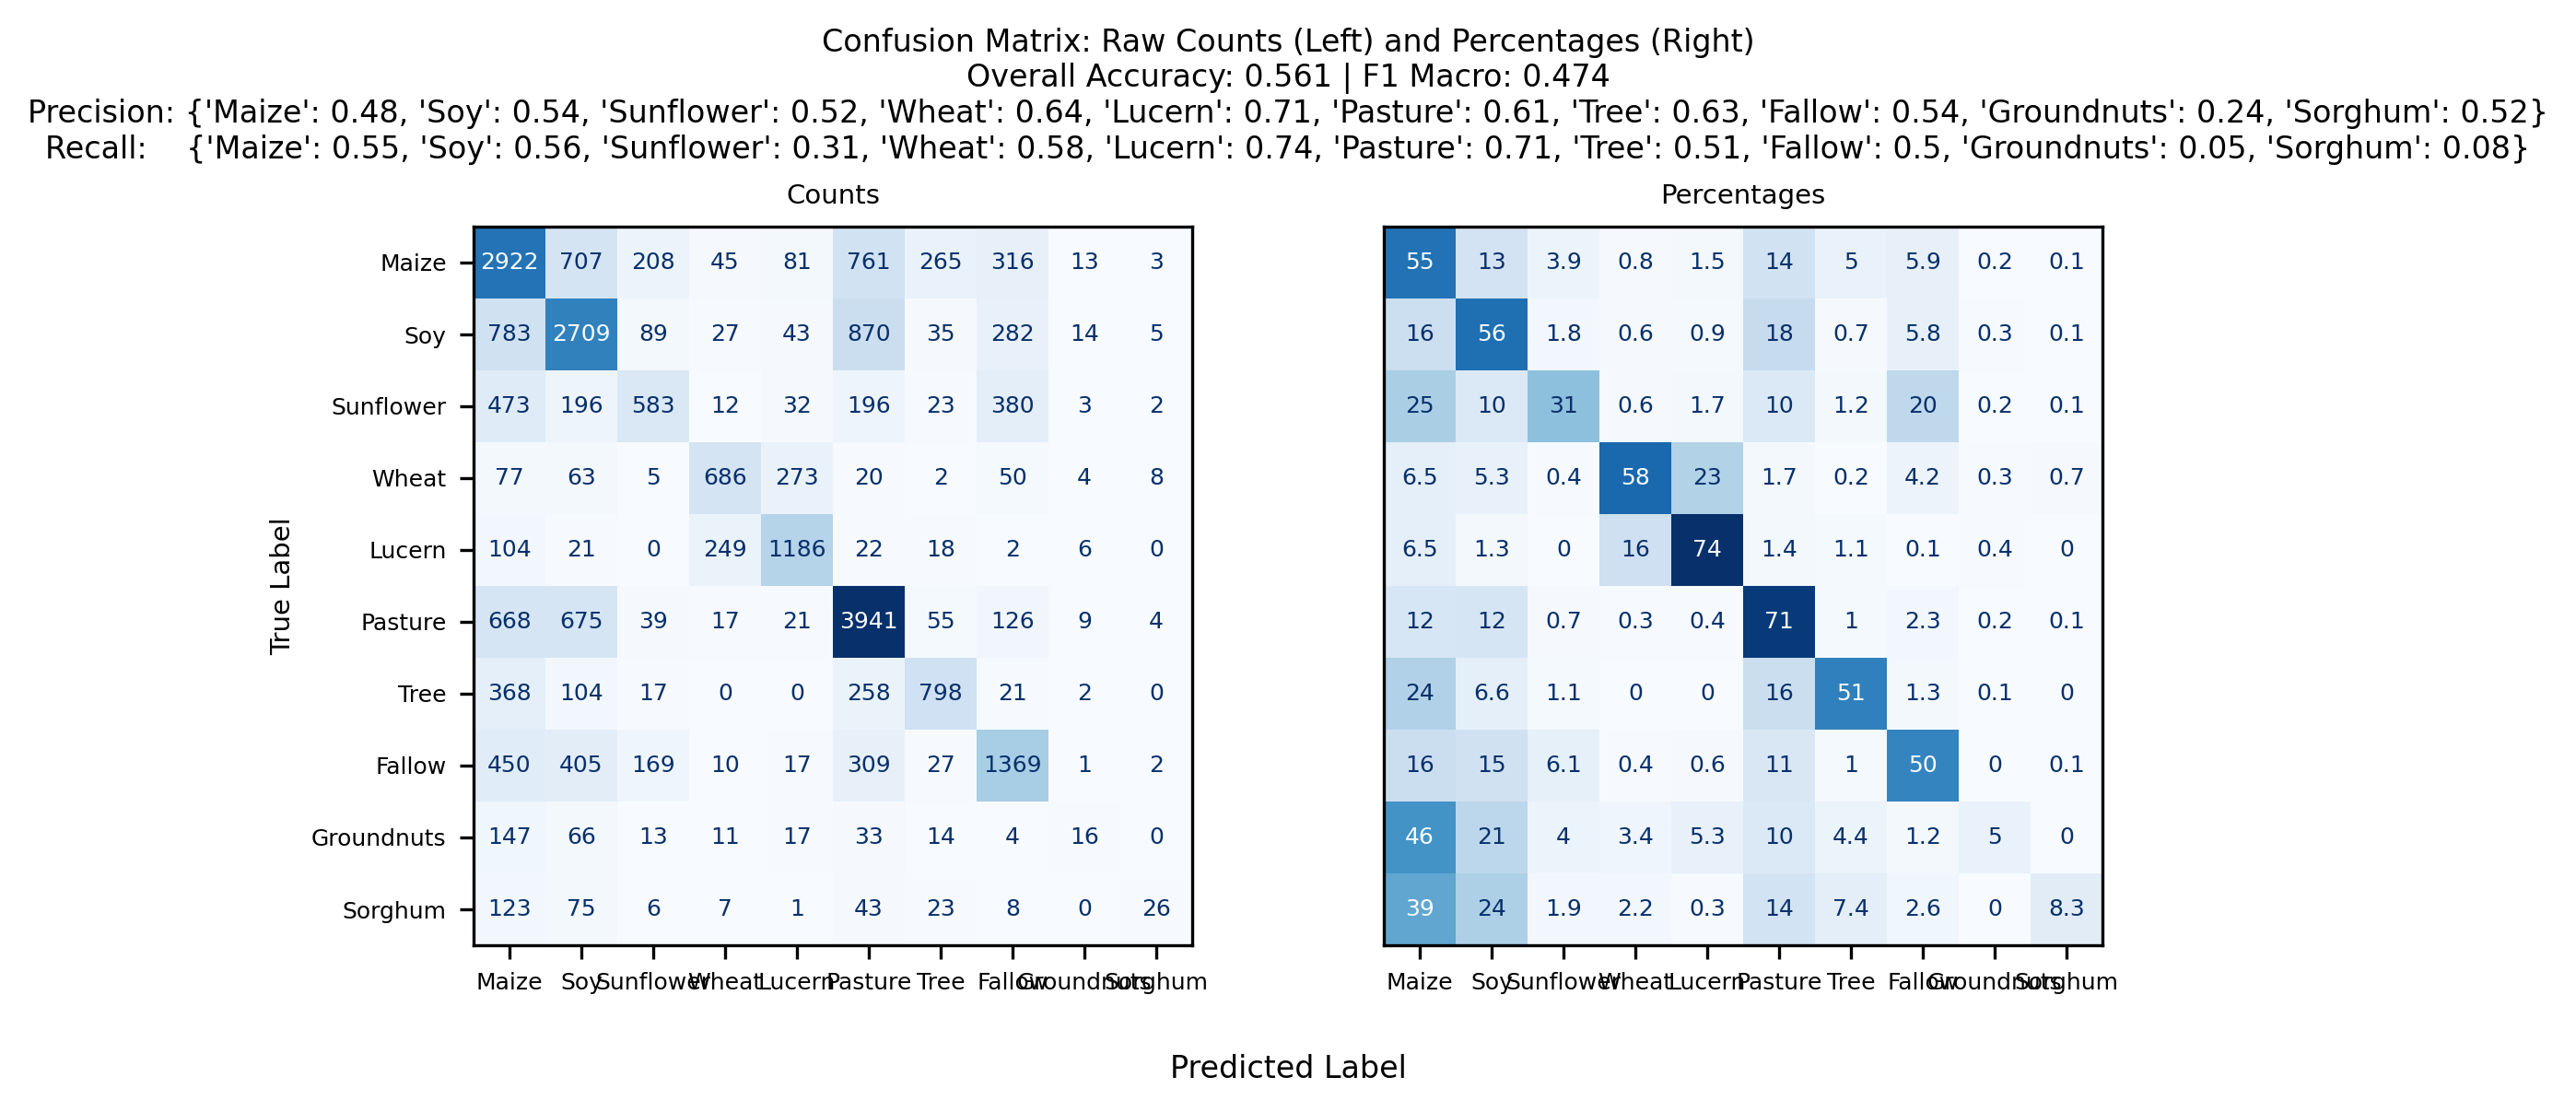

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import os

# 🔹 Normalize confusion matrix
conf_matrix = confusion_matrix(y, predictions)
cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
cm_normalized = np.around(cm_normalized, decimals=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
ax1.set_aspect(1.0 / ax1.get_data_ratio() * 0.8)
ax2.set_aspect(1.0 / ax2.get_data_ratio() * 0.8)

# 🔹 Raw counts
disp1 = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=[crop_name_mapping[label] for label in np.unique(y)]
)
disp1.plot(ax=ax1, cmap='Blues', colorbar=False)
ax1.set_title('Counts', fontsize=7)
ax1.set_ylabel('True Label', fontsize=7)
ax1.set_xlabel('')
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
for text in ax1.texts:
    text.set_fontsize(6)

# 🔹 Percentages
disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized,
    display_labels=[crop_name_mapping[label] for label in np.unique(y)]
)
disp2.plot(ax=ax2, cmap='Blues', colorbar=False)
ax2.set_title('Percentages', fontsize=7)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)
for text in ax2.texts:
    text.set_fontsize(6)

plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.15, wspace=-0.3)
fig.text(0.5, 0.03, 'Predicted Label', ha='center', fontsize=8)

# 🔹 INSERT THIS BLOCK HERE (before fig.suptitle)
precision = precision_score(y, predictions, average=None)
recall = recall_score(y, predictions, average=None)

fig.suptitle(
    'Confusion Matrix: Raw Counts (Left) and Percentages (Right)\n'
    f'Overall Accuracy: {np.mean(overall_acc):.3f} | '
    f'F1 Macro: {np.mean(f1_macro):.3f}\n'
    f'Precision: {dict(zip([crop_name_mapping[label] for label in np.unique(y)], np.around(precision, 2)))}\n'
    f'Recall:    {dict(zip([crop_name_mapping[label] for label in np.unique(y)], np.around(recall, 2)))}',
    fontsize=8
)

# 🔹 Save and display
confmat_path = os.path.join(model_pic_basepath, f'{dataset_name}{reduction_method}_matrix.png')
plt.savefig(confmat_path, dpi=300, bbox_inches="tight")
plt.close()

from IPython.display import Image, display
display(Image(filename=confmat_path))


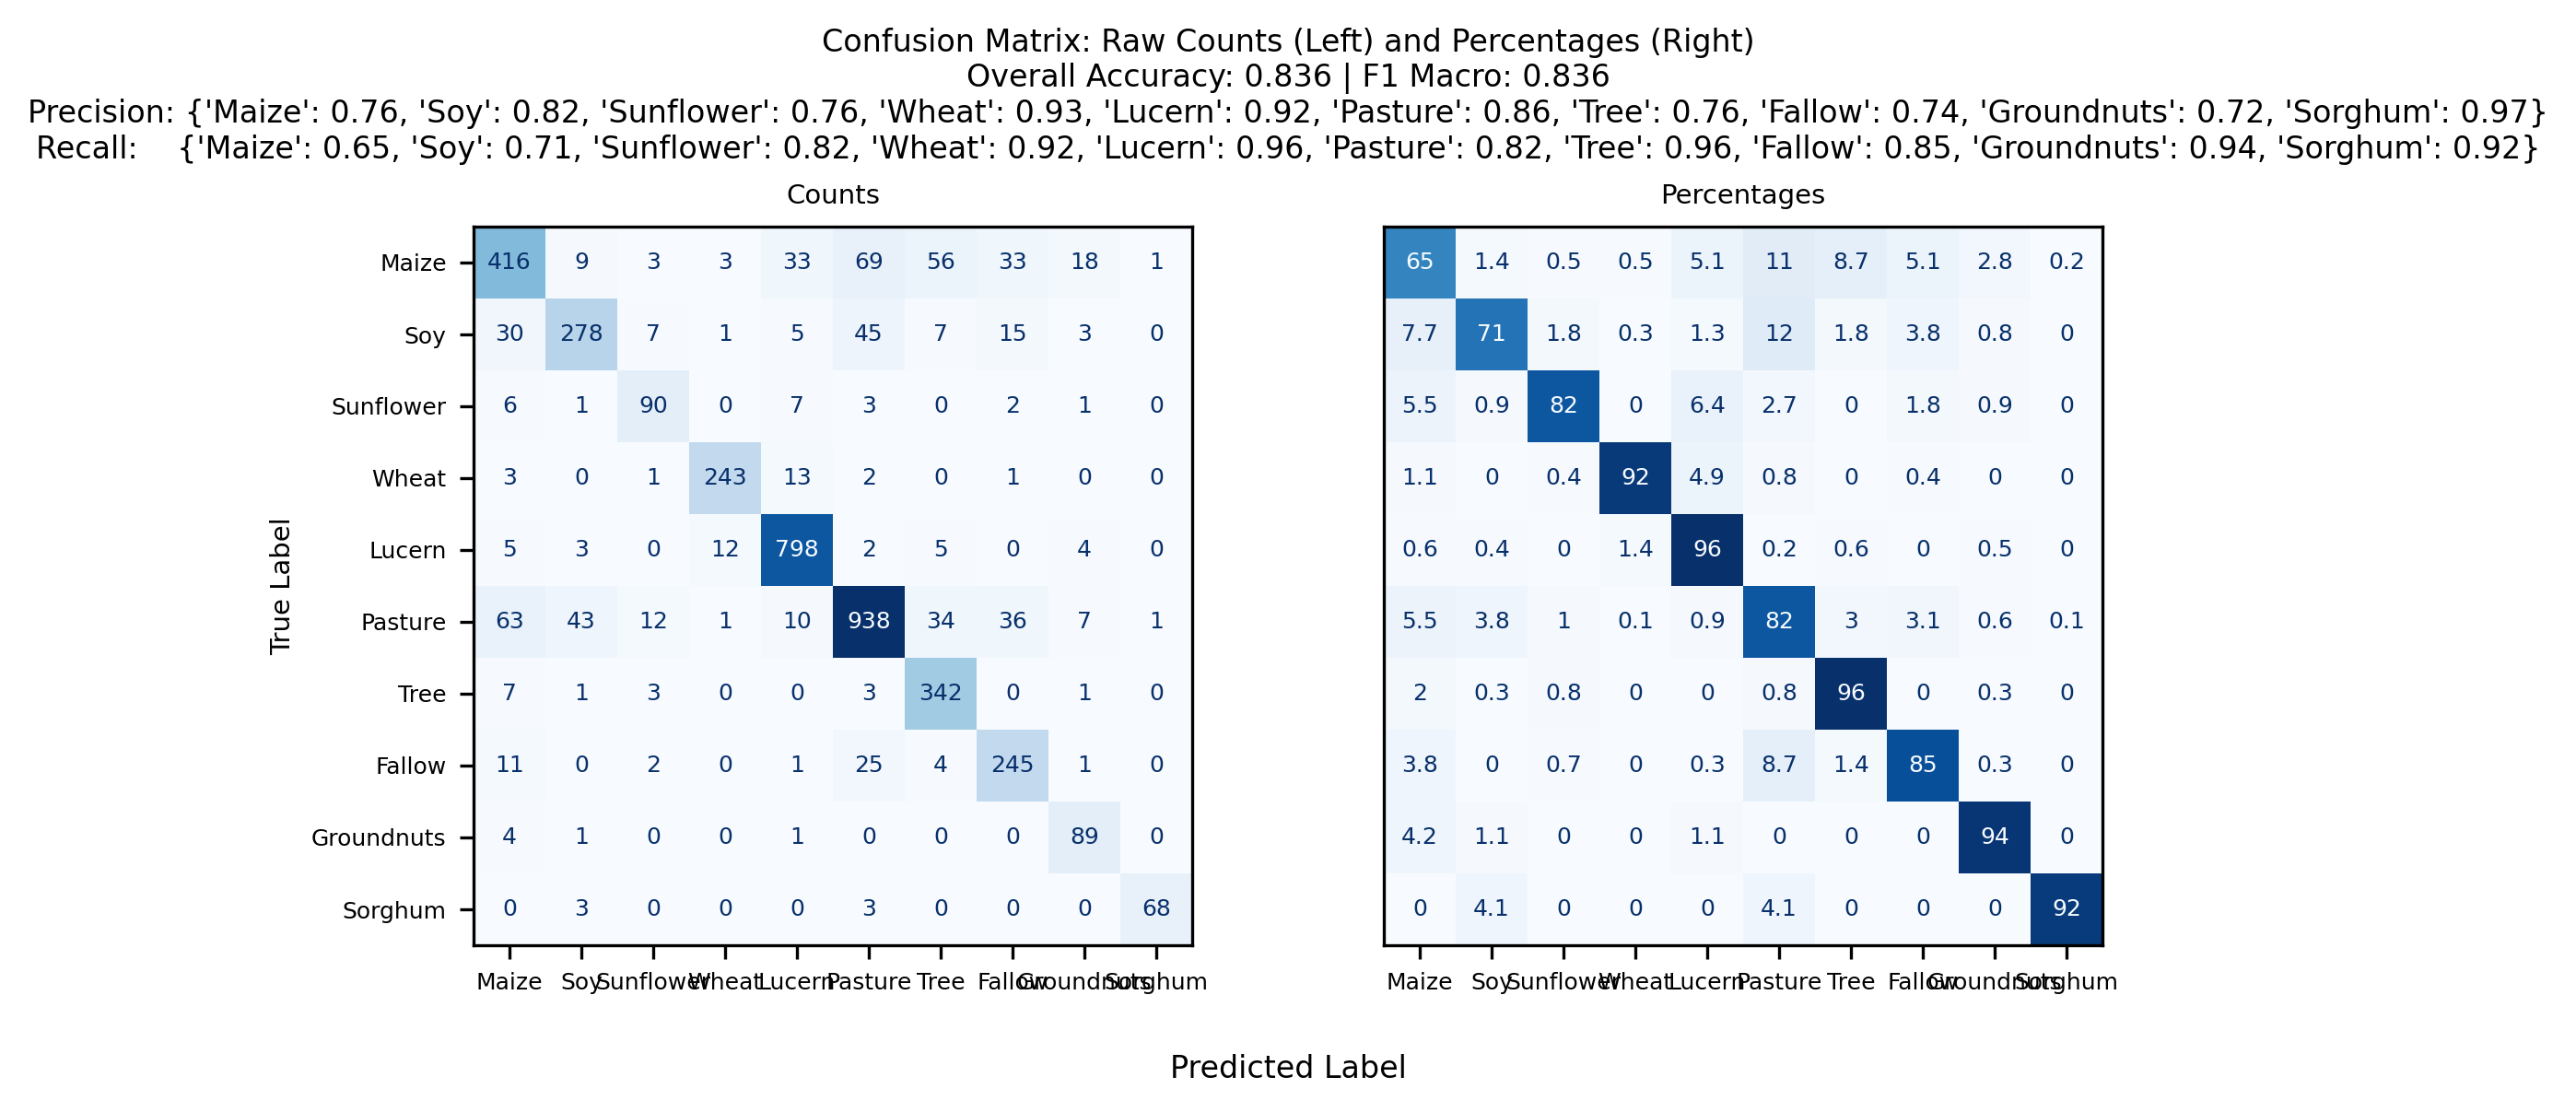

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from IPython.display import Image, display

# 🔹 Ensure you're predicting on the true test set
y_test_pred = xgb2.predict(X_test)

# 🔹 Confusion matrix and normalized version
conf_matrix = confusion_matrix(y_test, y_test_pred)
cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
cm_normalized = np.around(cm_normalized, decimals=1)

# 🔹 Class label mapping
labels = np.unique(y_test)
label_names = [crop_name_mapping[label] for label in labels]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
ax1.set_aspect(1.0 / ax1.get_data_ratio() * 0.8)
ax2.set_aspect(1.0 / ax2.get_data_ratio() * 0.8)

# 🔹 Raw counts
disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
disp1.plot(ax=ax1, cmap='Blues', colorbar=False)
ax1.set_title('Counts', fontsize=7)
ax1.set_ylabel('True Label', fontsize=7)
ax1.set_xlabel('')
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
for text in ax1.texts:
    text.set_fontsize(6)

# 🔹 Percentages
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=label_names)
disp2.plot(ax=ax2, cmap='Blues', colorbar=False)
ax2.set_title('Percentages', fontsize=7)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)
for text in ax2.texts:
    text.set_fontsize(6)

plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.15, wspace=-0.3)
fig.text(0.5, 0.03, 'Predicted Label', ha='center', fontsize=8)

# 🔹 Precision and Recall (test set only)
precision = precision_score(y_test, y_test_pred, average=None)
recall = recall_score(y_test, y_test_pred, average=None)
overall_acc = np.mean(y_test_pred == y_test)
from sklearn.metrics import f1_score
f1_macro = f1_score(y_test, y_test_pred, average='macro')

fig.suptitle(
    'Confusion Matrix: Raw Counts (Left) and Percentages (Right)\n'
    f'Overall Accuracy: {overall_acc:.3f} | '
    f'F1 Macro: {f1_macro:.3f}\n'
    f'Precision: {dict(zip(label_names, np.around(precision, 2)))}\n'
    f'Recall:    {dict(zip(label_names, np.around(recall, 2)))}',
    fontsize=8
)

# 🔹 Save and display
confmat_path = os.path.join(model_pic_basepath, f'{dataset_name}{reduction_method}_test_matrix.png')
plt.savefig(confmat_path, dpi=300, bbox_inches="tight")
plt.close()
display(Image(filename=confmat_path))

## Save the Final Model and Features

Finally, we save the final model and the selected features.

In [69]:
# Save model and features
model_path = os.path.join(model_basepath, f'{dataset_name}{reduction_method}.joblib')
dump(xgb2, model_path)

['Models/SB25r_n0.2_process_filt.joblib']

In [70]:
features_path = os.path.join(model_basepath, f'{dataset_name}{reduction_method}.json')
with open(features_path, "w", encoding="utf-8") as f:
    json.dump({"features": list(selected_columns)}, f, ensure_ascii=False, indent=4)

In [71]:
from sklearn.metrics import f1_score

# ➤ Evaluate on full dataset
X_full = df1[selected_columns].values
y_full = df1[label_col].values.ravel()
preds_final = xgb2.predict(X_full)

accuracy = accuracy_score(y_full, preds_final)
f1_weighted = f1_score(y_full, preds_final, average='weighted')

print(f"✔️ Final accuracy: {accuracy:.4f}")
print(f"✔️ Weighted F1 score: {f1_weighted:.4f}")

# ✅ Save evaluation summary with all relevant metadata
summary = {
    "Final_Accuracy": round(accuracy, 4),
    "Weighted_F1": round(f1_weighted, 4),
    "Selected_Features": list(selected_columns),
    "Num_Selected_Features": len(selected_columns),
    "Model_File": model_path,
    "Features_File": features_path,
    "True_Test_Report_File": report_path,
    "Confusion_Matrix_Image": cm_image_path,
    "Confusion_Matrix_CSV": cm_csv_path
}

summary_file = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_evaluation_summary.json")
with open(summary_file, "w") as f:
    json.dump(summary, f, indent=2)

print(f"✔️ Evaluation summary saved to {summary_file}")



✔️ Final accuracy: 0.8129
✔️ Weighted F1 score: 0.8107
✔️ Evaluation summary saved to Models_Pictures/SB25r_n0.2_process_filt_evaluation_summary.json


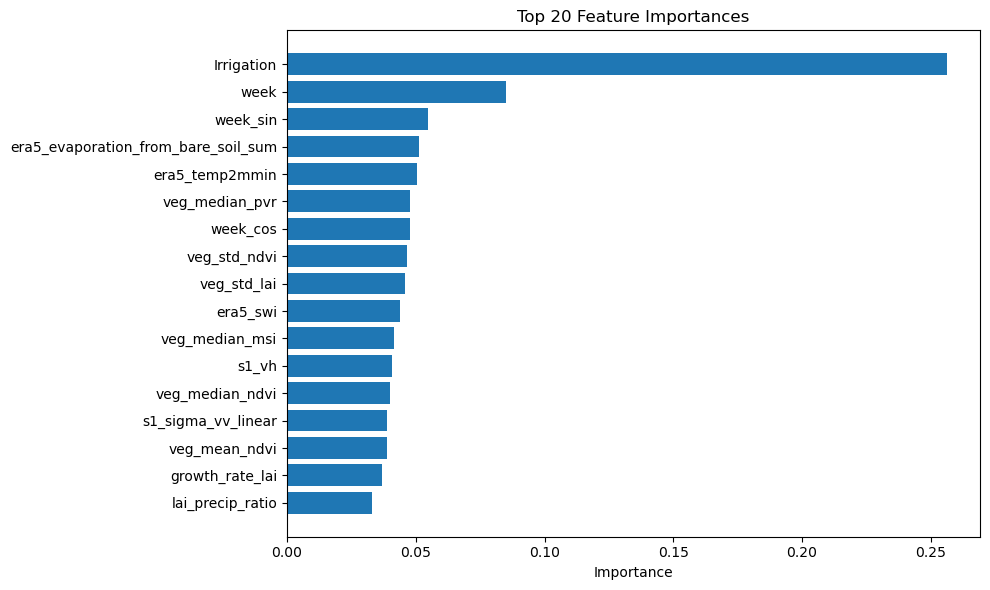

✔️ Feature importance plot saved to: Models_Pictures/SB25r_n0.2_process_filt_feature_importance.png


In [72]:
# ➤ Feature Importance Plot
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from trained model
importances = xgb2.feature_importances_
feature_names = selected_columns  # FFS-selected features

# Build a DataFrame for sorting
imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 20 features
top_k = 20
plt.figure(figsize=(10, 6))
plt.barh(imp_df["Feature"].head(top_k)[::-1], imp_df["Importance"].head(top_k)[::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances")
plt.tight_layout()

# Save plot
fig_path = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_feature_importance.png")
plt.savefig(fig_path)
plt.show()

print(f"✔️ Feature importance plot saved to: {fig_path}")


In [73]:
from sklearn.metrics import classification_report

# ➤ Print detailed per-class metrics
print("\n🔍 Per-class performance metrics:")
print(classification_report(y_full, preds_final, digits=3))


# ➤ Optional: Save report to file
report = classification_report(y_full, preds_final, digits=3)
report_path = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)

print(f"📄 Per-class report saved to: {report_path}")



🔍 Per-class performance metrics:
              precision    recall  f1-score   support

           0      0.831     0.658     0.735      5321
           1      0.831     0.770     0.800      4857
           2      0.744     0.851     0.794      1900
           3      0.904     0.941     0.922      1188
           4      0.882     0.961     0.920      1608
           5      0.834     0.836     0.835      5555
           6      0.747     0.945     0.834      1568
           7      0.758     0.878     0.813      2759
           8      0.658     0.897     0.759       321
           9      0.861     0.891     0.876       312

    accuracy                          0.813     25389
   macro avg      0.805     0.863     0.829     25389
weighted avg      0.817     0.813     0.811     25389

📄 Per-class report saved to: Models_Pictures/SB25r_n0.2_process_filt_classification_report.txt


In [74]:
from sklearn.metrics import classification_report

# ➤ Define readable class labels
crop_name_mapping = {
    0: 'Maize',
    1: 'Soy',
    2: 'Sunflower',
    3: 'Wheat',
    4: 'Lucern',
    5: 'Pasture',
    6: 'Tree',
    7: 'Fallow',
    8: 'Groundnuts',
    9: 'Sorghum'
}
target_names = [crop_name_mapping[i] for i in sorted(crop_name_mapping.keys())]

# ➤ Print detailed per-class metrics for test set
print("\n🔍 Per-class performance metrics (True Test Set Only):")
print(classification_report(y_test, y_test_pred, target_names=target_names, digits=3))

# ➤ Optional: Save report to file
report = classification_report(y_test, y_test_pred, target_names=target_names, digits=3)
report_path = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_testset_classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)

print(f"📄 Test set per-class report saved to: {report_path}")



🔍 Per-class performance metrics (True Test Set Only):
              precision    recall  f1-score   support

       Maize      0.763     0.649     0.702       641
         Soy      0.820     0.711     0.762       391
   Sunflower      0.763     0.818     0.789       110
       Wheat      0.935     0.924     0.929       263
      Lucern      0.919     0.963     0.940       829
     Pasture      0.861     0.819     0.839      1145
        Tree      0.763     0.958     0.850       357
      Fallow      0.738     0.848     0.789       289
  Groundnuts      0.718     0.937     0.813        95
     Sorghum      0.971     0.919     0.944        74

    accuracy                          0.836      4194
   macro avg      0.825     0.855     0.836      4194
weighted avg      0.838     0.836     0.834      4194

📄 Test set per-class report saved to: Models_Pictures/SB25r_n0.2_process_filt_testset_classification_report.txt


📊 SHAP summary plot saved to: Models_Pictures/SB25r_n0.2_process_filt_shap_summary.png


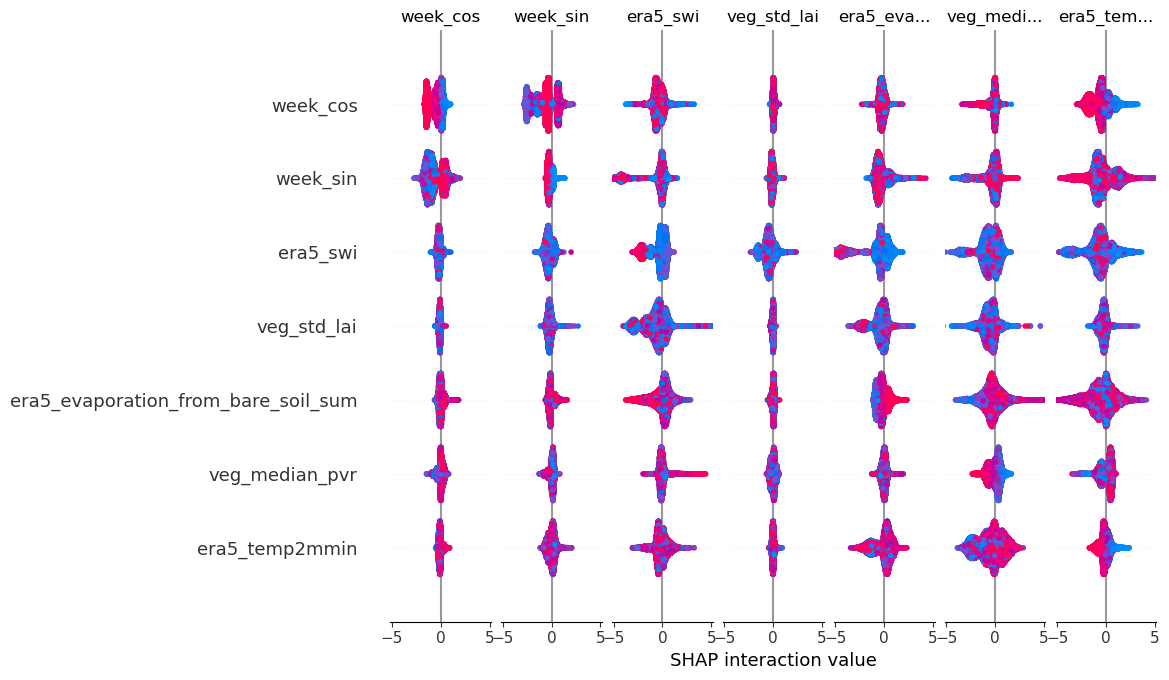

<Figure size 640x480 with 0 Axes>

In [75]:
import shap
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

# ➤ Create TreeExplainer for XGBoost model
explainer = shap.TreeExplainer(xgb2)

# ➤ Compute SHAP values
shap_values = explainer.shap_values(X_full)

# ➤ SHAP summary plot (bar + beeswarm)
plt.figure()
shap.summary_plot(shap_values, X_full, feature_names=selected_columns, show=False)
shap_plot_path = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_shap_summary.png")
plt.savefig(shap_plot_path, bbox_inches='tight')
plt.close()

print(f"📊 SHAP summary plot saved to: {shap_plot_path}")

# ➤ Display the image below the cell
display(Image(filename=shap_plot_path))
